# 🧠 Bone Age and Final Height Prediction
**RSNA Bone Age Challenge Dataset**

This notebook uses a ConvNeXt-based model to predict bone age from hand X-ray images.  
It then combines the predicted bone age with additional tabular features (current height, parental heights, BMI, sex) to estimate the child's final adult height.

⚠️ **Important:**  
Due to the large size of the datasets, images and annotations must be downloaded manually from the [official RSNA Bone Age Challenge dataset](https://www.rsna.org/en/education/ai-resources-and-training/ai-image-challenge/rsna-pediatric-bone-age-challenge).

---

# 📋 Project Structure

- **Data Preparation**: Loading images and tabular data.
- **Feature Engineering**: Preprocessing X-rays and tabular features.
- **Model Building**: Using ConvNeXt + tabular input combined model.
- **Training and Validation**: Predicting bone age and final height.
- **Notes**: Dataset is not included.


# 📚 Install and Import Required Libraries


In [ ]:
# 📚 Install and Import Required Libraries

import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import convnext_tiny

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Mount Google Drive

In [ ]:
# 🔗 Mount Google Drive to access dataset files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extract zip files

In [3]:
# 📂 Extract Dataset ZIP Files

# Paths to ZIP files in Google Drive
annotations_zip = "/content/drive/MyDrive/Bone+Age+Training+Set+Annotations.zip"
images_zip = "/content/drive/MyDrive/Bone+Age+Training+Set.zip"

# Paths where files will be extracted
annotations_dir = "/content/rsna_annotations"
images_dir = "/content/xray_images"

# Create directories if they do not exist
os.makedirs(annotations_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)

# Extract annotation files
print("Extracting annotation files...")
with zipfile.ZipFile(annotations_zip, 'r') as zip_ref:
    zip_ref.extractall(annotations_dir)

# Extract image files
print("Extracting image files...")
with zipfile.ZipFile(images_zip, 'r') as zip_ref:
    zip_ref.extractall(images_dir)

print("✅ Extraction completed successfully.")


Extracting annotation files...
Extracting image files...
✅ Extraction completed successfully.


# Load the Clean CSV and Prepare the DataFrame

In [4]:
# 📄 Load the Clean CSV and Prepare the DataFrame

import os
import pandas as pd

# Load CSV
csv_path = "/content/rsna_annotations/train.csv"  # Adjust if needed
df = pd.read_csv(csv_path)

print(f"✅ CSV loaded successfully with {len(df)} rows.")

# Add full image path correctly
images_dir = "/content/xray_images"  # Base images folder

df['image_path'] = df['id'].apply(lambda x: os.path.join(images_dir, "boneage-training-dataset", f"{x}.png"))

# Check if 'male' column exists
if 'male' not in df.columns:
    raise ValueError("❌ The CSV does not contain the expected 'male' column.")

# ⚡ Filter rows where image file exists
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

print(f"✅ After filtering, remaining samples: {len(df)}")

# Show first few rows
df.head()




✅ CSV loaded successfully with 12611 rows.
✅ After filtering, remaining samples: 12611


,id,boneage,male,image_path
0,1377,180,False,/content/xray_images/boneage-training-dataset/...
1,1378,12,False,/content/xray_images/boneage-training-dataset/...
2,1379,94,False,/content/xray_images/boneage-training-dataset/...
3,1380,120,True,/content/xray_images/boneage-training-dataset/...
4,1381,82,False,/content/xray_images/boneage-training-dataset/...


# Create Custom Dataset for Bone Age Prediction (ConvNeXt-Tiny Model)

In [5]:
# 🛠️ Create Custom Dataset for Bone Age Prediction (ConvNeXt-Tiny Model)

class BoneAgeDataset(Dataset):
    def __init__(self, dataframe, transform=None, tabular_features=None):
        """
        Args:
            dataframe (DataFrame): Pandas DataFrame with image paths and tabular data.
            transform (callable, optional): Optional transform to be applied on an image.
            tabular_features (list, optional): List of tabular column names to be used as input.
        """
        self.dataframe = dataframe.reset_index(drop=True)  # Reset index to avoid errors
        self.transform = transform
        self.tabular_features = tabular_features

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load image
        img_path = self.dataframe.loc[idx, 'image_path']
        image = Image.open(img_path).convert('RGB')  # Ensure image is RGB

        # Apply image transforms
        if self.transform:
            image = self.transform(image)

        # Load tabular features
        if self.tabular_features and len(self.tabular_features) > 0:
            tabular_data = self.dataframe.loc[idx, self.tabular_features].values.astype(np.float32)
            tabular_data = torch.tensor(tabular_data)
        else:
            tabular_data = torch.tensor([])

        # Load target (bone age)
        target = torch.tensor(self.dataframe.loc[idx, 'boneage']).float()

        return image, tabular_data, target


# Define Image Transformations for ConvNeXt-Tiny

In [6]:
# 🎨 Define Image Transformations for ConvNeXt-Tiny

import torchvision.transforms as transforms

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Imagenet mean
        std=[0.229, 0.224, 0.225]    # Imagenet std
    )
])

print("✅ Image transformations defined successfully.")


✅ Image transformations defined successfully.


# ⚡ Split dataset into Training and Validation sets

In [ ]:
# ⚡ Split dataset into Training and Validation sets

# Define features you want to use (tabular)
tabular_features = ['male']  # 👈 Important: use 'male', not 'sex'

# Split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create datasets
train_dataset = BoneAgeDataset(
    dataframe=train_df,
    transform=image_transforms,
    tabular_features=tabular_features
)

val_dataset = BoneAgeDataset(
    dataframe=val_df,
    transform=image_transforms,
    tabular_features=tabular_features
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("✅ Train and Validation DataLoaders are ready.")


✅ Train and Validation DataLoaders are ready.


# 🧠 Define the ConvNeXt-Tiny model combined with Tabular Data

In [7]:
# ✅ Correct model matching training setup (ConvNeXt + Tabular input)

import torch
import torch.nn as nn
from torchvision.models import convnext_tiny
from torchvision import transforms
from PIL import Image
import numpy as np

# Model Architecture
class BoneAgeFullModel(nn.Module):
    def __init__(self):
        super(BoneAgeFullModel, self).__init__()

        self.cnn = convnext_tiny(pretrained=False)
        self.cnn.classifier = nn.Identity()  # Remove classifier head

        self.tabular_net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.combined_fc = nn.Sequential(
            nn.Linear(768 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Predict Bone Age
        )

    def forward(self, image, tabular):
        img_features = self.cnn(image)
        img_features = img_features.mean(dim=[2, 3])  # Global Average Pooling
        tabular_features = self.tabular_net(tabular)
        combined = torch.cat((img_features, tabular_features), dim=1)
        output = self.combined_fc(combined)
        return output.squeeze(1)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Model
model = BoneAgeFullModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/bone_age_project/best_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Image preprocessing (same as during training)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Imagenet mean
        std=[0.229, 0.224, 0.225]    # Imagenet std
    )
])

# Prediction Function: Predict Bone Age from X-ray image
def predict_bone_age_from_image(image_np):
    img = Image.fromarray(image_np).convert('RGB')
    img = image_transforms(img).unsqueeze(0).to(device)

    # Create dummy input for tabular data
    tabular_dummy = torch.zeros((1, 1)).to(device)

    with torch.no_grad():
        bone_age_months = model(img, tabular_dummy).cpu().numpy().flatten()[0]
    return bone_age_months


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# ⚙️ Setup Optimizer, Loss Function and Device

In [8]:
# ⚙️ Setup Optimizer, Loss Function and Device

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# Initialize the model
model = BoneAgeModel(tabular_input_dim=len(tabular_features))
model = model.to(device)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()


✅ Using device: cuda


NameError: name 'BoneAgeModel' is not defined

# 🚂 Training and Validation Loop

In [ ]:
# 🚂 Training and Validation Loop (Saving Best Model in Google Drive)

from sklearn.metrics import mean_absolute_error
import numpy as np
import torch
import os
from tqdm import tqdm

# Define path in Drive to save best model
drive_checkpoint_path = "/content/drive/MyDrive/bone_age_project/best_model.pth"
os.makedirs(os.path.dirname(drive_checkpoint_path), exist_ok=True)

# Number of epochs
num_epochs = 20

# Track the best validation loss
best_val_loss = np.inf

# Lists to store history
train_losses = []
val_losses = []
train_mae_scores = []
val_mae_scores = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_targets = []

    for images, tabular_data, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images = images.to(device)
        tabular_data = tabular_data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images, tabular_data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_preds.extend(outputs.detach().cpu().numpy())
        train_targets.extend(targets.detach().cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_mae = mean_absolute_error(train_targets, train_preds)

    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for images, tabular_data, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images = images.to(device)
            tabular_data = tabular_data.to(device)
            targets = targets.to(device)

            outputs = model(images, tabular_data)
            loss = criterion(outputs, targets)

            val_loss += loss.item() * images.size(0)
            val_preds.extend(outputs.detach().cpu().numpy())
            val_targets.extend(targets.detach().cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_mae = mean_absolute_error(val_targets, val_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_mae_scores.append(train_mae)
    val_mae_scores.append(val_mae)

    # Save best model directly into Google Drive
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), drive_checkpoint_path)
        print(f"✅ Model improved and was saved in Drive at epoch {epoch+1}!")

    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Train MAE: {train_mae:.2f}")
    print(f"Val Loss:   {val_loss:.4f} | Val MAE:   {val_mae:.2f}")


Epoch 1/20 [Val]: 100%|██████████| 79/79 [00:53<00:00,  1.49it/s]


✅ Model improved and was saved in Drive at epoch 1!
Epoch [1/20]
Train Loss: 2624.5379 | Train MAE: 35.14
Val Loss:   270.8201 | Val MAE:   13.04


Epoch 2/20 [Val]: 100%|██████████| 79/79 [00:52<00:00,  1.49it/s]


Epoch [2/20]
Train Loss: 281.7239 | Train MAE: 12.92
Val Loss:   367.6647 | Val MAE:   15.84


Epoch 3/20 [Val]: 100%|██████████| 79/79 [00:52<00:00,  1.50it/s]


✅ Model improved and was saved in Drive at epoch 3!
Epoch [3/20]
Train Loss: 176.8149 | Train MAE: 10.14
Val Loss:   209.9114 | Val MAE:   11.65


Epoch 4/20 [Val]: 100%|██████████| 79/79 [00:52<00:00,  1.49it/s]


✅ Model improved and was saved in Drive at epoch 4!
Epoch [4/20]
Train Loss: 129.9381 | Train MAE: 8.79
Val Loss:   164.0985 | Val MAE:   10.21


Epoch 5/20 [Val]: 100%|██████████| 79/79 [00:53<00:00,  1.49it/s]


✅ Model improved and was saved in Drive at epoch 5!
Epoch [5/20]
Train Loss: 98.1772 | Train MAE: 7.41
Val Loss:   157.6895 | Val MAE:   9.91


Epoch 6/20 [Val]: 100%|██████████| 79/79 [00:53<00:00,  1.48it/s]


Epoch [6/20]
Train Loss: 62.8391 | Train MAE: 5.98
Val Loss:   281.5324 | Val MAE:   13.92


Epoch 7/20 [Val]: 100%|██████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch [7/20]
Train Loss: 49.8104 | Train MAE: 5.15
Val Loss:   189.5478 | Val MAE:   11.04


Epoch 8/20 [Val]: 100%|██████████| 79/79 [00:51<00:00,  1.52it/s]


Epoch [8/20]
Train Loss: 39.4900 | Train MAE: 4.54
Val Loss:   188.6528 | Val MAE:   10.96


Epoch 9/20 [Val]: 100%|██████████| 79/79 [00:51<00:00,  1.54it/s]


Epoch [9/20]
Train Loss: 30.9327 | Train MAE: 4.00
Val Loss:   184.9510 | Val MAE:   10.87


Epoch 10/20 [Val]: 100%|██████████| 79/79 [00:51<00:00,  1.55it/s]


✅ Model improved and was saved in Drive at epoch 10!
Epoch [10/20]
Train Loss: 30.7958 | Train MAE: 3.85
Val Loss:   153.4124 | Val MAE:   9.79


Epoch 11/20 [Val]: 100%|██████████| 79/79 [00:50<00:00,  1.56it/s]


✅ Model improved and was saved in Drive at epoch 11!
Epoch [11/20]
Train Loss: 27.4557 | Train MAE: 3.66
Val Loss:   138.1541 | Val MAE:   9.19


Epoch 12/20 [Val]: 100%|██████████| 79/79 [00:50<00:00,  1.56it/s]


Epoch [12/20]
Train Loss: 26.8569 | Train MAE: 3.52
Val Loss:   218.8594 | Val MAE:   12.07


Epoch 13/20 [Val]: 100%|██████████| 79/79 [00:50<00:00,  1.55it/s]


✅ Model improved and was saved in Drive at epoch 13!
Epoch [13/20]
Train Loss: 25.2660 | Train MAE: 3.56
Val Loss:   131.9449 | Val MAE:   8.91


Epoch 14/20 [Val]: 100%|██████████| 79/79 [00:51<00:00,  1.54it/s]


✅ Model improved and was saved in Drive at epoch 14!
Epoch [14/20]
Train Loss: 23.2152 | Train MAE: 3.31
Val Loss:   126.2534 | Val MAE:   8.70


Epoch 15/20 [Val]: 100%|██████████| 79/79 [00:51<00:00,  1.55it/s]


Epoch [15/20]
Train Loss: 17.1357 | Train MAE: 3.05
Val Loss:   158.2494 | Val MAE:   9.92


Epoch 16/20 [Val]: 100%|██████████| 79/79 [00:50<00:00,  1.55it/s]


Epoch [16/20]
Train Loss: 16.5395 | Train MAE: 2.95
Val Loss:   152.0630 | Val MAE:   9.64


Epoch 17/20 [Val]: 100%|██████████| 79/79 [00:51<00:00,  1.54it/s]


Epoch [17/20]
Train Loss: 16.3875 | Train MAE: 2.93
Val Loss:   130.6493 | Val MAE:   8.89


Epoch 18/20 [Val]: 100%|██████████| 79/79 [00:51<00:00,  1.54it/s]


Epoch [18/20]
Train Loss: 15.9903 | Train MAE: 2.87
Val Loss:   134.9231 | Val MAE:   9.12


Epoch 19/20 [Val]: 100%|██████████| 79/79 [00:51<00:00,  1.53it/s]


Epoch [19/20]
Train Loss: 17.0176 | Train MAE: 3.10
Val Loss:   135.1556 | Val MAE:   9.11


Epoch 20/20 [Val]: 100%|██████████| 79/79 [00:50<00:00,  1.55it/s]


✅ Model improved and was saved in Drive at epoch 20!
Epoch [20/20]
Train Loss: 17.8731 | Train MAE: 3.11
Val Loss:   115.9325 | Val MAE:   8.31


# Evaluate model

📊 Model Evaluation Metrics:
Mean Absolute Error (MAE): 8.31 months
Mean Squared Error (MSE): 115.93
R2 Score: 0.9345


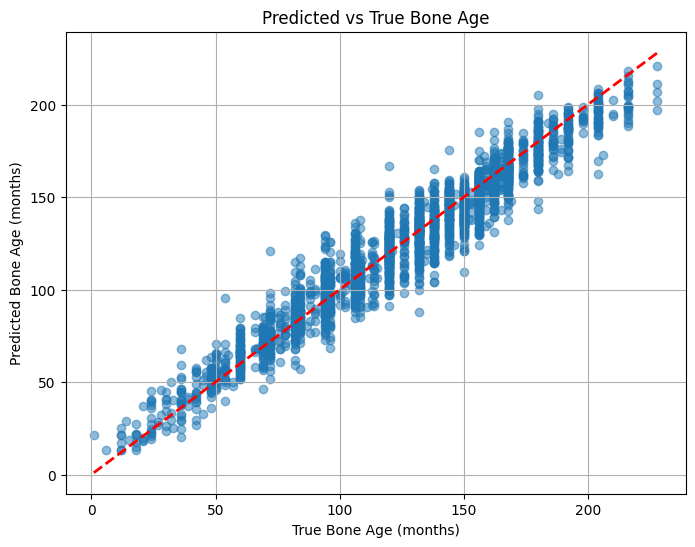

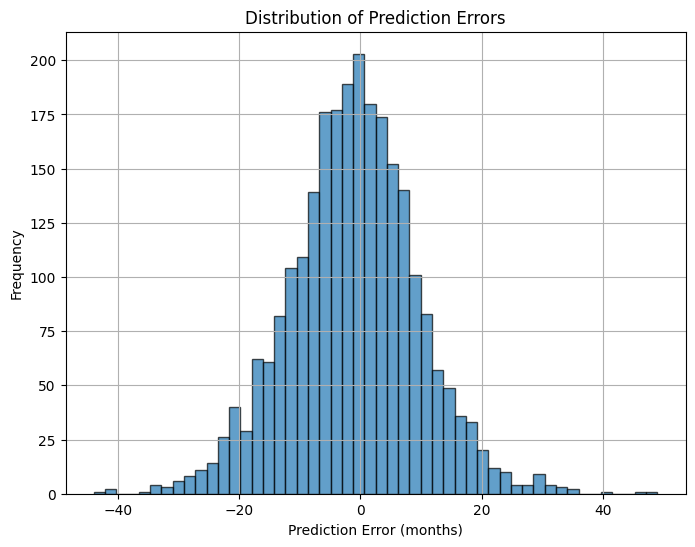

In [ ]:
# 🧪 Full Evaluation: Metrics + Plots

import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ✅ Path to your best model in Google Drive
best_model_path = "/content/drive/MyDrive/bone_age_project/best_model.pth"

# ✅ Re-initialize your model
model = BoneAgeModel(tabular_input_dim=len(tabular_features))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# ✅ Load weights (even if in CPU)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# ✅ Collect predictions and true targets
val_preds = []
val_targets = []

with torch.no_grad():
    for images, tabular_data, targets in val_loader:
        images = images.to(device)
        tabular_data = tabular_data.to(device)
        targets = targets.to(device)

        outputs = model(images, tabular_data)

        val_preds.extend(outputs.cpu().numpy())
        val_targets.extend(targets.cpu().numpy())

# ✅ Convert lists to numpy arrays
val_preds = np.array(val_preds)
val_targets = np.array(val_targets)

# ✅ Calculate regression metrics
mae = mean_absolute_error(val_targets, val_preds)
mse = mean_squared_error(val_targets, val_preds)
r2 = r2_score(val_targets, val_preds)

# ✅ Print results
print("📊 Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f} months")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R2 Score: {r2:.4f}")

# 📈 Scatter Plot: Predicted vs True
plt.figure(figsize=(8,6))
plt.scatter(val_targets, val_preds, alpha=0.5)
plt.plot([val_targets.min(), val_targets.max()], [val_targets.min(), val_targets.max()], 'r--', lw=2)
plt.xlabel('True Bone Age (months)')
plt.ylabel('Predicted Bone Age (months)')
plt.title('Predicted vs True Bone Age')
plt.grid(True)
plt.show()

# 📈 Histogram of Errors
errors = val_preds - val_targets
plt.figure(figsize=(8,6))
plt.hist(errors, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error (months)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()


In [ ]:
# 🧪 Classification Metrics for Regression Task (Bone Age Ranges)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define bone age classes (ranges in months)
def age_to_class(age):
    if age < 24:
        return 0  # 0-24 months
    elif age < 48:
        return 1  # 24-48 months
    elif age < 72:
        return 2  # 48-72 months
    elif age < 96:
        return 3  # 72-96 months
    elif age < 120:
        return 4  # 96-120 months
    elif age < 144:
        return 5  # 120-144 months
    else:
        return 6  # >144 months

# ✅ Collect predictions and true targets (Validation)
model.eval()
val_preds = []
val_targets = []

with torch.no_grad():
    for images, tabular_data, targets in val_loader:
        images = images.to(device)
        tabular_data = tabular_data.to(device)
        targets = targets.to(device)

        outputs = model(images, tabular_data)

        val_preds.extend(outputs.cpu().numpy())
        val_targets.extend(targets.cpu().numpy())

# Convert predictions and targets to numpy arrays
val_preds = np.array(val_preds)
val_targets = np.array(val_targets)

# Convert ages to classes
val_preds_class = np.array([age_to_class(x) for x in val_preds])
val_targets_class = np.array([age_to_class(x) for x in val_targets])

# 🛠️ Calculate classification report
print("📊 Classification Report (Validation):")
print(classification_report(val_targets_class, val_preds_class, digits=4))

# 🛠️ Calculate and plot confusion matrix
cm = confusion_matrix(val_targets_class, val_preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    '0-24m', '24-48m', '48-72m', '72-96m', '96-120m', '120-144m', '>144m'
])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Validation Set (Bone Age Classes)")
plt.grid(False)
plt.show()


#Creating a function to calculate Height

In [ ]:
# 🧮 Predict Final Height based on Bone Age, Chronological Age, and Genetic Target

def predict_final_height_from_inputs(
    age_chronological_years,
    bone_age_years,
    current_height,
    father_height,
    mother_height,
    sex
):
    """
    Predict final height based on bone age, chronological age, current height, and genetic target.
    """

    # Step 1: Calculate Genetic Target and Genetic Band
    if sex.upper() == 'M':
        target_height = (father_height + mother_height + 13) / 2
        genetic_band = 8.5
    elif sex.upper() == 'F':
        target_height = (father_height + mother_height - 13) / 2
        genetic_band = 8.0
    else:
        raise ValueError("Sex must be 'M' or 'F'.")

    # Step 2: Assess Maturity Status
    maturity_gap_months = (bone_age_years - age_chronological_years) * 12
    if maturity_gap_months > 12:
        maturity_status = "Advanced Maturity"
    elif maturity_gap_months < -12:
        maturity_status = "Delayed Maturity"
    else:
        maturity_status = "Normal Maturity"

    # Step 3: Estimate residual growth (simplified table based on bone age)
    def estimate_residual_growth(bone_age_years):
        if bone_age_years <= 11:
            return 22.5
        elif bone_age_years <= 12:
            return 19.5
        elif bone_age_years <= 13:
            return 15.0
        elif bone_age_years <= 14:
            return 10.0
        elif bone_age_years <= 15:
            return 5.0
        elif bone_age_years <= 16:
            return 2.0
        else:
            return 0.0

    expected_growth = estimate_residual_growth(bone_age_years)

    # Step 4: Predict final height
    predicted_final_height = current_height + expected_growth

    # Step 5: Apply Genetic Target Band (clip if necessary)
    lower_limit = target_height - genetic_band
    upper_limit = target_height + genetic_band

    if predicted_final_height > upper_limit:
        predicted_final_height = upper_limit
    elif predicted_final_height < lower_limit:
        predicted_final_height = lower_limit

    # Step 6: Return Results
    results = {
        "Maturity Status": maturity_status,
        "Expected Growth (cm)": round(expected_growth, 1),
        "Predicted Final Height (cm)": round(predicted_final_height, 1),
        "Genetic Target Height (cm)": round(target_height, 1),
        "Allowed Range (cm)": f"{round(lower_limit,1)} - {round(upper_limit,1)}"
    }

    return results


# Create a front end for uploading X-Ray and user data

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 135.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
# 🏥 Gradio App: Upload X-ray ➔ Predict Bone Age ➔ Predict Final Height

import gradio as gr
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torchvision.models import convnext_tiny
from PIL import Image

# ✅ Correct Model Architecture matching training
class BoneAgeFullModel(nn.Module):
    def __init__(self):
        super(BoneAgeFullModel, self).__init__()

        self.cnn = convnext_tiny(pretrained=False)
        self.cnn.classifier = nn.Identity()

        self.tabular_net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.combined_fc = nn.Sequential(
            nn.Linear(768 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_features = self.cnn(image)
        img_features = img_features.mean(dim=[2, 3])  # Global Average Pooling
        tabular_features = self.tabular_net(tabular)
        combined = torch.cat((img_features, tabular_features), dim=1)
        output = self.combined_fc(combined)
        return output.squeeze(1)

# ✅ Load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BoneAgeFullModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/bone_age_project/best_model.pth', map_location=device))
model = model.to(device)
model.eval()

# ✅ Image preprocessing (same as during training)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Predict Bone Age from X-ray
def predict_bone_age_from_image(image_np):
    img = Image.fromarray(image_np).convert('RGB')
    img = image_transforms(img).unsqueeze(0).to(device)

    # Dummy input for tabular
    tabular_dummy = torch.zeros((1, 1)).to(device)

    with torch.no_grad():
        bone_age_months = model(img, tabular_dummy).cpu().numpy().flatten()[0]
    return bone_age_months

# ✅ New Final Height Prediction (no Pinney multipliers)
def predict_final_height_from_inputs(
    age_chronological_years,
    bone_age_years,
    current_height,
    father_height,
    mother_height,
    sex
):
    # Step 1: Calculate Genetic Target and Band
    if sex.upper() == 'M':
        target_height = (father_height + mother_height + 13) / 2
        genetic_band = 8.5
    elif sex.upper() == 'F':
        target_height = (father_height + mother_height - 13) / 2
        genetic_band = 8.0
    else:
        raise ValueError("Sex must be 'M' or 'F'.")

    # Step 2: Assess maturity
    maturity_gap_months = (bone_age_years - age_chronological_years) * 12
    if maturity_gap_months > 12:
        maturity_status = "Advanced Maturity"
    elif maturity_gap_months < -12:
        maturity_status = "Delayed Maturity"
    else:
        maturity_status = "Normal Maturity"

    # Step 3: Estimate residual growth (custom table)
    def estimate_residual_growth(bone_age_years):
        if bone_age_years <= 11:
            return 22.5
        elif bone_age_years <= 12:
            return 19.5
        elif bone_age_years <= 13:
            return 15.0
        elif bone_age_years <= 14:
            return 10.0
        elif bone_age_years <= 15:
            return 5.0
        elif bone_age_years <= 16:
            return 2.0
        else:
            return 0.0

    expected_growth = estimate_residual_growth(bone_age_years)

    # Step 4: Predict final height
    predicted_final_height = current_height + expected_growth

    # Step 5: Clip by genetic target range
    lower_limit = target_height - genetic_band
    upper_limit = target_height + genetic_band

    if predicted_final_height > upper_limit:
        predicted_final_height = upper_limit
    elif predicted_final_height < lower_limit:
        predicted_final_height = lower_limit

    results = {
        "Maturity Status": maturity_status,
        "Expected Growth (cm)": round(expected_growth, 1),
        "Predicted Final Height (cm)": round(predicted_final_height, 1),
        "Genetic Target Height (cm)": round(target_height, 1),
        "Allowed Range (cm)": f"{round(lower_limit,1)} - {round(upper_limit,1)}"
    }

    return results

# ✅ Gradio function to connect everything
def gradio_predict_final_height(xray_image, age_chronological_months, current_height, father_height, mother_height, sex):
    try:
        # Step 1: Predict Bone Age
        bone_age_months = predict_bone_age_from_image(xray_image)
        bone_age_years = bone_age_months / 12
        age_chronological_years = age_chronological_months / 12

        # Step 2: Predict Final Height
        results = predict_final_height_from_inputs(
            age_chronological_years=age_chronological_years,
            bone_age_years=bone_age_years,
            current_height=float(current_height),
            father_height=float(father_height),
            mother_height=float(mother_height),
            sex=sex
        )

        # Step 3: Format output
        output_text = f"""🧠 Maturity Status: {results['Maturity Status']}

🖼️ Predicted Bone Age from X-ray: {round(bone_age_months,1)} months

📈 Expected Growth Remaining: {results['Expected Growth (cm)']} cm
📏 Predicted Final Height: {results['Predicted Final Height (cm)']} cm
🎯 Genetic Target Height: {results['Genetic Target Height (cm)']} cm
📊 Allowed Range: {results['Allowed Range (cm)']}
"""
        return output_text
    except Exception as e:
        return f"❌ Error: {str(e)}"

# 🎛️ Gradio Interface
iface = gr.Interface(
    fn=gradio_predict_final_height,
    inputs=[
        gr.Image(type="numpy", label="Upload Hand X-ray"),
        gr.Number(label="Chronological Age (in months)"),
        gr.Number(label="Current Height (in cm)"),
        gr.Number(label="Father's Height (in cm)"),
        gr.Number(label="Mother's Height (in cm)"),
        gr.Radio(["M", "F"], label="Sex (M/F)")
    ],
    outputs="text",
    title="🏥 Bone Age ➔ Final Height Predictor (Corrected Model)",
    description="Upload a hand X-ray to predict bone age automatically, then input basic info to estimate expected final adult height based on growth tables."
)

iface.launch(debug=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a525f3be2fe636d85c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a525f3be2fe636d85c.gradio.live
